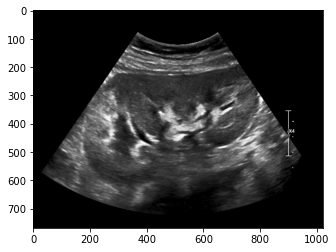

In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import skimage.transform
from scipy.ndimage import map_coordinates
import scipy
import scipy.ndimage
from skimage.measure import label, regionprops
from skimage.morphology import convex_hull_image

img = cv2.imread("2_IM-0383-0001_anon.png")
plt.imshow(img)

In [2]:
def find_mask(img, threshold=1/800, index=-2):
    v = to_grayscale(img / 255)

    diff_mean = (np.clip(v, 0, 1))
    # find connected components after threshold
    cc = label(diff_mean > threshold)
    v, c = np.unique(cc, return_counts=True)
    # find second largest connect component (largest is the background)
    second_largest_component = v[c.tolist().index(sorted(c)[index])]

    # take convex hull to remove small gaps
    # noinspection PyTypeChecker
    return convex_hull_image(np.where(cc == second_largest_component, 1, 0))

In [3]:
def to_grayscale(im):
    if im.shape[-1] == 3:
        return np.dot(im[..., :3], [0.299, 0.587, 0.114])
    else:
        return im

In [4]:
def zoom(img, com, scale):
    img_shape = img.shape
    if img.ndim==3:
        zoomed = scipy.ndimage.zoom(img, (scale, scale, 1))
    else:
        zoomed = scipy.ndimage.zoom(img, scale)
    r_offset = min(max(0, int(scale * com[0] - img.shape[0] / 2)), zoomed.shape[0] - img.shape[0])
    c_offset = min(max(0, int(scale * com[1] - img.shape[1] / 2)), zoomed.shape[1] - img.shape[1])

    if img.ndim==3:
        return zoomed[r_offset:r_offset + img.shape[0], c_offset:c_offset + img.shape[1],:]
    else:
        return zoomed[r_offset:r_offset + img.shape[0], c_offset:c_offset + img.shape[1]]


In [5]:
def zoom_augmentation(img, zoom=1.25):
    mask = find_mask(img, index=-2)
    com = scipy.ndimage.measurements.center_of_mass(mask)
    zoomed = zoom(img, com, 1.25)
    if len(img.shape) == 3:
        mask = np.expand_dims(mask, -1)
    masked = mask * zoomed
    return masked

In [6]:
masked = zoom_augmentation(img)
plt.imshow(masked)

TypeError: 'float' object is not callable